# Airbnb Price Prediction

## Data preprocessing

### Exploring the data

In [44]:
# Imports

import pandas as pd
import numpy as np

In [45]:
# Importing the training data

data = pd.read_csv('../../data/train_airbnb_berlin.csv', delimiter = ',')
data.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,...,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,...,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,...,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


In [47]:
# Important preprocessing: replacing all '*' strings by NaNs

data[data == '*'] = np.nan

In [48]:
# Global overview of the data

print(data.shape)
data.describe()

(15692, 39)


,Listing ID,Host ID,Latitude,Longitude,Square Feet,Reviews,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price
count,1.569100e+04,1.569200e+04,15692.000000,15692.000000,303.000000,15692.000000,12730.000000,12721.000000,12722.000000,12719.000000,12722.000000,12721.000000,12720.000000,15683.000000
mean,1.780062e+07,6.119042e+07,52.509893,13.407334,445.900990,19.452014,94.717282,9.717475,9.328407,9.769164,9.779201,9.556874,9.458097,60.342983
std,9.952544e+06,6.739421e+07,0.031286,0.058646,414.817342,39.483853,7.069787,0.671793,1.023807,0.620347,0.619545,0.731109,0.788891,48.829687
min,2.241500e+04,1.101500e+04,52.369270,13.121400,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000
25%,9.052831e+06,9.274528e+06,52.488920,13.376025,0.000000,1.000000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,32.000000
50%,1.865037e+07,3.358182e+07,52.509100,13.417250,440.000000,5.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,49.000000
75%,2.611308e+07,9.325677e+07,52.532713,13.439750,700.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,70.000000
max,3.467450e+07,2.609698e+08,52.639670,13.709020,1912.000000,424.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,900.000000


In [49]:
# Exploring the features with less than 200 DISTINCT values

for feature in data.columns.tolist():
    unique_list = data[feature].unique().tolist()
    if len(unique_list) < 200:
        print(f'{feature} (n = {len(unique_list)}): \n{unique_list}\n')

Listing Name (n = 1): 
[nan]

Host Response Time (n = 5): 
[nan, 'within a few hours', 'within an hour', 'within a day', 'a few days or more']

Host Response Rate (n = 34): 
[nan, '92%', '100%', '80%', '71%', '83%', '98%', '78%', '89%', '50%', '90%', '70%', '20%', '97%', '91%', '88%', '75%', '93%', '0%', '67%', '33%', '40%', '58%', '86%', '60%', '95%', '94%', '96%', '82%', '63%', '99%', '87%', '25%', '30%']

Is Superhost (n = 3): 
['f', 't', nan]

neighbourhood (n = 63): 
['Prenzlauer Berg', 'Pankow', 'Friedrichshain', 'Mariendorf', 'Wilmersdorf', 'Kreuzberg', 'Moabit', 'NeukÃ¶lln', 'Alt-Treptow', 'SchÃ¶neberg', 'Reinickendorf', 'Mitte', 'Karlshorst', 'WeiÃ\x9fensee', 'Friedenau', 'Hansaviertel', 'Wedding', 'Charlottenburg', 'Steglitz', 'Baumschulenweg', 'Alt-HohenschÃ¶nhausen', 'Rummelsburg', 'Lichterfelde', 'OberschÃ¶neweide', 'Britz', 'Lichtenberg', 'Grunewald', 'Altglienicke', 'Westend', 'Tempelhof', 'Marzahn', 'Mahlsdorf', 'Adlershof', 'NiederschÃ¶nhausen', 'Tegel', 'Rahnsdorf', '

In [50]:
# Checking the proportion of missing values for each feature

data.isnull().sum()/data.shape[0]

Listing ID               0.000064
Listing Name             1.000000
Host ID                  0.000000
Host Name                0.001402
Host Since               0.001338
Host Response Time       0.450867
Host Response Rate       0.461955
Is Superhost             0.001466
neighbourhood            0.012937
Neighborhood Group       0.000000
City                     0.003059
Postal Code              0.070036
Country Code             0.000000
Country                  0.000000
Latitude                 0.000000
Longitude                0.000000
Is Exact Location        0.000000
Property Type            0.004780
Room Type                0.000000
Accomodates              0.001211
Bathrooms                0.001593
Bedrooms                 0.001020
Beds                     0.001275
Square Feet              0.980691
Guests Included          0.000637
Min Nights               0.015868
Reviews                  0.000000
First Review             0.172381
Last Review              0.172445
Overall Rating

The preprocessing of the data will be done in two phases: the first one, the preliminary data preprocessing, will be common to all Machine Learning approaches that will be used in this project. Since different approaches require different preprocessings, the second phase will be specific to each one.

### Preliminary data preprocessing

In [51]:
few_missing = data[["Host Since",
                    "Is Superhost",
                    "Property Type",
                    "Accomodates",
                    "Bathrooms",
                    "Bedrooms",
                    "Beds",
                    "Guests Included",
                    "Min Nights",
                    "Price"]].isnull().sum()

print(f"Missing values per feature:\n\n{few_missing}\n")

# Proportion of instances with missing values in the aforementioned features

few_missing_prop = few_missing.sum()/data.shape[0]

print(f"Proportion of instances with missing values in the aforementioned features:\n\n{few_missing_prop}")

Missing values per feature:

Host Since          21
Is Superhost        23
Property Type       75
Accomodates         19
Bathrooms           25
Bedrooms            16
Beds                20
Guests Included     10
Min Nights         249
Price                9
dtype: int64

Proportion of instances with missing values in the aforementioned features:

0.02976038745857762


The instances with missing values in the aforementioned attributes represent merely 3% of the entire dataset (as given above by *few_missing_prop*). We can therefore reasonably assume they are Missing Completely At Random (MCAR), which allows us to perform listwise deletion.

In [52]:
def preliminary_preprocessing(data):

    # We remove all features that are deemed irrelevant for the price prediction

    data_clean = data.drop(["Host Name",
                            "Host ID",
                            "Listing ID",
                            "Listing Name",
                            "neighbourhood",
                            "City",
                            "Country Code",
                            "Country",
                            "Postal Code",
                            "Square Feet", 
                            "First Review",
                            "Last Review",
                            "Business Travel Ready"], axis=1)

    # Removing instances with NaNs in the aforementioned features 

    data_clean = data_clean.dropna(subset=["Host Since",
                                           "Is Superhost",
                                           "Property Type",
                                           "Accomodates",
                                           "Bathrooms",
                                           "Bedrooms",
                                           "Beds",
                                           "Guests Included",
                                           "Min Nights",
                                           "Price"])

    # Let's fill NaN values by "unknown" where we can

    data_clean = data_clean.replace({"Host Response Time": np.nan}, "unknown")

    # Replacing binary values by 0 and 1

    data_clean = data_clean.replace({"Is Superhost": "t"}, 1)
    data_clean = data_clean.replace({"Is Superhost": "f"}, 0)
    data_clean["Is Superhost"] = data_clean["Is Superhost"].astype(float)    

    data_clean = data_clean.replace({"Is Exact Location": "t"}, 1)
    data_clean = data_clean.replace({"Is Exact Location": "f"}, 0)
    data_clean["Is Exact Location"] = data_clean["Is Exact Location"].astype(float)

    data_clean = data_clean.replace({"Instant Bookable": "t"}, 1)
    data_clean = data_clean.replace({"Instant Bookable": "f"}, 0)
    data_clean["Instant Bookable"] = data_clean["Instant Bookable"].astype(float)

    # Converting certain numeric features into floats (they were strings)

    data_clean["Accomodates"] = data_clean["Accomodates"].astype(float)
    data_clean["Bathrooms"] = data_clean["Bathrooms"].astype(float)
    data_clean["Bedrooms"] = data_clean["Bedrooms"].astype(float)      
    data_clean["Beds"] = data_clean["Beds"].astype(float)          
    data_clean["Guests Included"] = data_clean["Guests Included"].astype(float)
    data_clean["Min Nights"] = data_clean["Min Nights"].astype(float)

    # String to float for 'Host Response Rate' (removing the '%')

    data_clean["Host Response Rate"] = data_clean["Host Response Rate"].str.rstrip("%").astype(float)

    # Changing host since into continous form

    data_clean["Host Since"] = pd.to_datetime(data_clean["Host Since"])
    most_recent =  max(data_clean["Host Since"])
    seniority = [(most_recent-x).days for x in data_clean["Host Since"]]
    data_clean["Host Since"] = seniority

    # One-hot encoding for categorical values

    dummies_response_time  = pd.get_dummies(data_clean[["Host Response Time"]])
    dummies_property_type = pd.get_dummies(data_clean[["Property Type"]])
    dummies_room_type = pd.get_dummies(data_clean[["Room Type"]])

    X_ = data_clean.drop(["Host Response Time", "Property Type", "Room Type"], axis=1)
    data_clean_final = pd.concat([X_, dummies_response_time, dummies_property_type, dummies_room_type], axis=1)
    
    return data_clean_final

In [53]:
data_clean = preliminary_preprocessing(data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab9ee52550>,
      dtype=object)

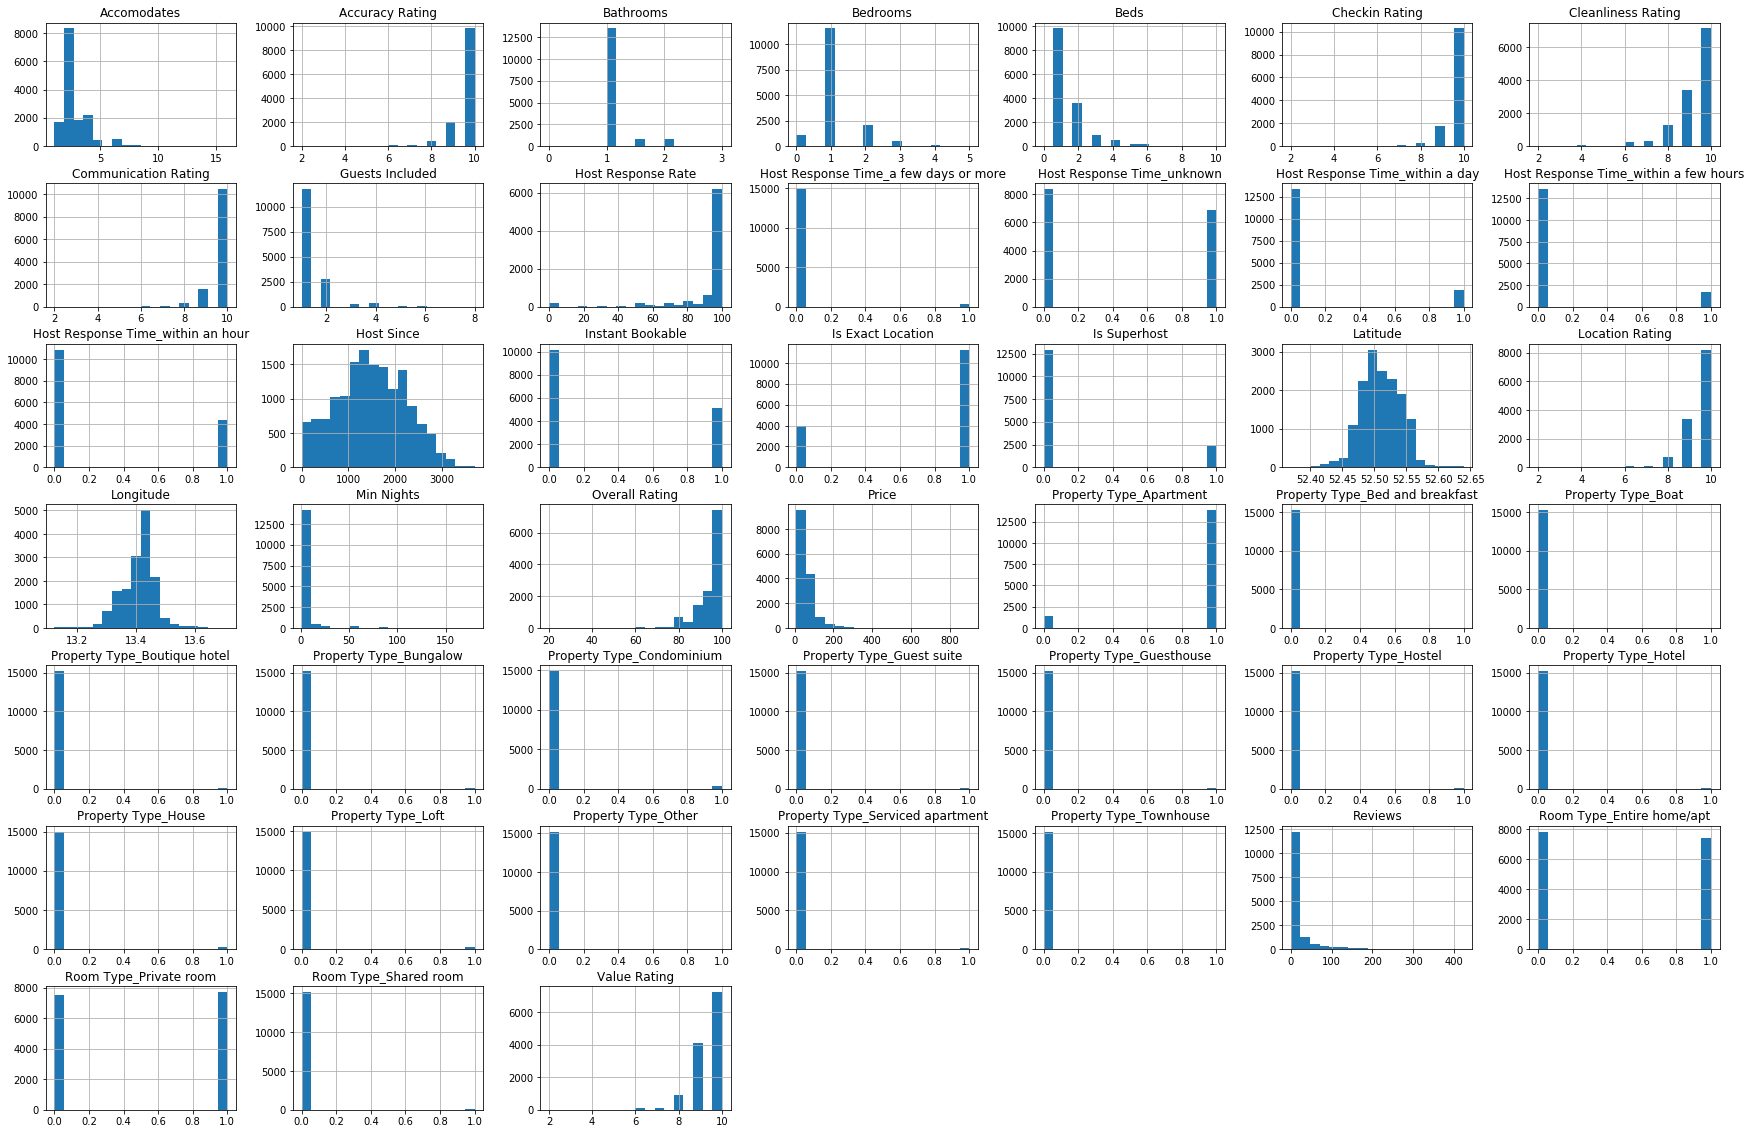

In [54]:
# Visualizing the distributions of the features in data_clean

data_clean.hist(figsize=(30,20),bins=18)

In [61]:
# Checking the proportion of missing values for the attributes where there are some left

features_missing = [feature for feature in data_clean.columns.tolist() if data_clean[feature].isna().sum()>0]
print(features_missing)

data_clean[features_missing].isna().sum()/data_clean.shape[0]

['Host Response Rate', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating']


Host Response Rate      0.462737
Overall Rating          0.184479
Accuracy Rating         0.185069
Cleanliness Rating      0.185003
Checkin Rating          0.185200
Communication Rating    0.185003
Location Rating         0.185069
Value Rating            0.185134
dtype: float64

We see that the proportion of missing values for these features is way too high to perform listwise selection. In order to preserve our data set, we have to impute them.